In [1]:
!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import calendar
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.weightstats import ztest 
import warnings

In [3]:
path_to_file = 'data/Grocery Database.xlsx'

In [4]:
df = pd.read_excel(path_to_file)

In [5]:
df = df.round(2)
df.head()

,Receipt Number,Date,Year,Month,Time,Mobile Number,Membership ID,Loyalty Card Points,Age,Gender,...,GST,Gross Bill Amount,Payment Mode,Bank Name,% Profit Margin,% Operating Cost,% Product Cost,Profit Margin,Operating Cost,Product Cost
0,GIJ00001,2016-01-02,2016,1,10:08:03.260000,9793548581,MIDID0001,1,36,Male,...,0.1,13.32,Card,Enterprise Bank,0.15,0.15,0.70,1.85,1.85,8.65
1,GIJ00002,2016-01-02,2016,1,15:46:50.832000,9938441276,MIDID0002,2,54,Male,...,0.1,25.26,Card,Philippine Veterans Bank,0.12,0.15,0.73,2.74,3.48,16.98
2,GIJ00003,2016-01-02,2016,1,11:28:52.166000,9976742552,MIDID0003,1,16,Female,...,0.1,42.19,Cash,BDO Unibank,0.15,0.15,0.70,1.96,2.00,9.36
3,GIJ00003,2016-01-02,2016,1,11:28:52.166000,9976742552,MIDID0003,1,16,Female,...,0.1,42.19,Cash,BDO Unibank,0.10,0.15,0.76,0.33,0.53,2.66
4,GIJ00003,2016-01-02,2016,1,11:28:52.166000,9976742552,MIDID0003,2,16,Female,...,0.1,42.19,Cash,BDO Unibank,0.12,0.15,0.73,0.53,0.66,3.22


In [6]:
warnings.filterwarnings("ignore")

## 1. Which countries and cities give the most profit?

In [7]:
df.groupby(['Country', 'City'])['Profit Margin'].sum().sort_values(ascending=False)


Country      City        
Singapore    Bedok           14649.04
Philippines  Manila          14454.95
Malaysia     Kuala Lumpur    12957.65
Indonesia    Jakarta         11068.78
Singapore    Woodlands        7489.07
Name: Profit Margin, dtype: float64

The cities of Bedok and Manila are the most profitable. Most profitable countries are Singapore and the Philippines.

## 2. Is the profit growing dynamically in each of the countries of sale?

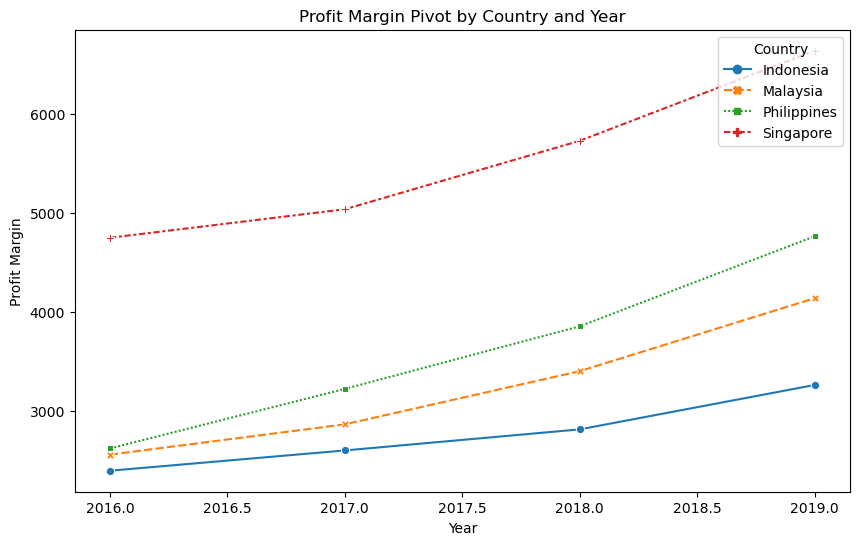

In [8]:
profit_margin_pivot = df.pivot_table(index='Year', columns='Country', values='Profit Margin', aggfunc='sum')


plt.figure(figsize=(10, 6))
sns.lineplot(data=profit_margin_pivot, markers=True)

plt.title('Profit Margin Pivot by Country and Year')
plt.xlabel('Year')
plt.ylabel('Profit Margin')

plt.legend(title='Country', loc='upper right')
plt.show()


Each of the countries in the dynamics shows an increase in profit.

## 3. Buyers of which gender have the highest average check in different cities?

In [9]:
gender_category_pivot = df.pivot_table(index='City', columns='Gender', values='Gross Bill Amount', aggfunc='mean').round(2)

gender_category_pivot.style.background_gradient(axis=1)

Gender,Female,Male
City,,
Bedok,70.670000,68.870000
Jakarta,74.410000,74.570000
Kuala Lumpur,72.300000,69.700000
Manila,73.450000,68.700000
Woodlands,74.530000,72.100000


In the vast majority of cities, women have a higher average check. We should focus more on women in our marketing campaigns.

## 4. Let's analyze which customers of which gender and age group bring the most profit

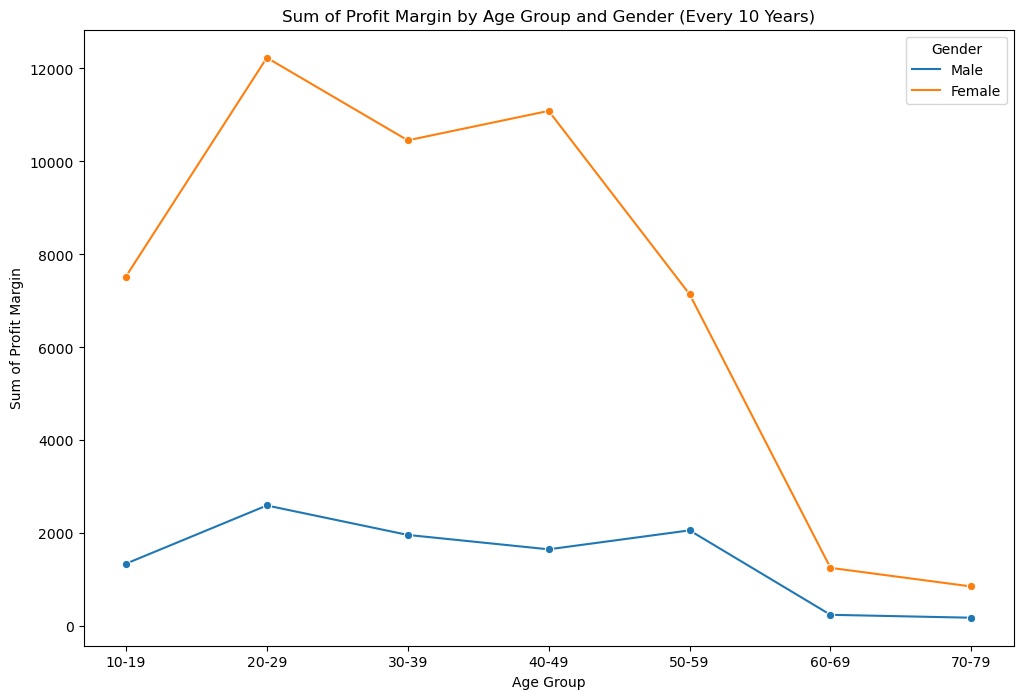

In [10]:
age_bins = np.arange(0, df['Age'].max() + 10, 10)
age_labels = [f'{start}-{start + 9}' for start in age_bins[:-1]]
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Age Group', y='Profit Margin', hue='Gender', estimator='sum', ci=None, marker='o')

plt.title('Sum of Profit Margin by Age Group and Gender (Every 10 Years)')
plt.xlabel('Age Group')
plt.ylabel('Sum of Profit Margin')
plt.legend(title='Gender')

plt.show()

Women generate the profits of our stores several times more. Since the average check for men and women is so different, we can conclude that women either choose more profitable products or visit stores much more often. We get the most profit from women aged 20 to 49.

## 5. Let's test the hypothesis that women shop in our stores much more often

In [11]:
gender_category_pivot = df.groupby(['City', 'Gender'])['Receipt Number'].nunique().unstack()

gender_category_pivot

Gender,Female,Male
City,,
Bedok,2846,318
Jakarta,1950,469
Kuala Lumpur,2134,702
Manila,2391,703
Woodlands,1467,68


Yes, women visit stores much more often in all cities.

## 6. Is there seasonality in sales?

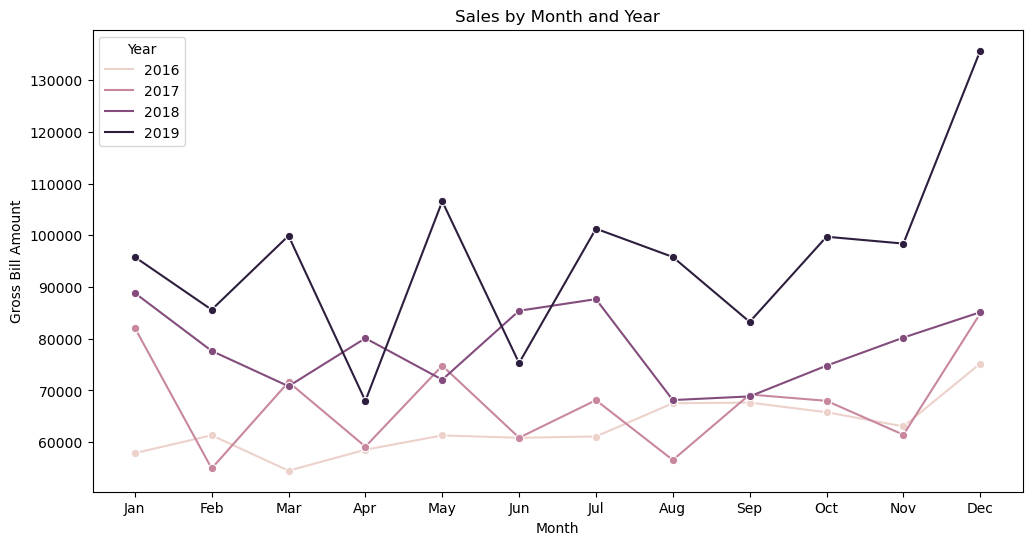

In [12]:
sales_by_month_year = df.groupby(['Year', 'Month'])['Gross Bill Amount'].sum()
sales_by_month_year_df = sales_by_month_year.reset_index()
sales_by_month_year_df['Month'] = sales_by_month_year_df['Month'].apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_by_month_year_df, x='Month', y='Gross Bill Amount', hue='Year', marker='o')

plt.title('Sales by Month and Year')
plt.xlabel('Month')
plt.ylabel('Gross Bill Amount')
plt.legend(title='Year')

plt.show()

Every year there is a clear increase in sales in December, which may be related to the preparation for the New Year and Christmas holidays. We suggest actively conducting advertising campaigns from the end of November and having a sufficient number of goods in stock.

## 7. What hours are the most popular for purchases?

In [13]:
df['Hour'] = df['Time'].apply(lambda x: x.hour)

count_unique_receipts_by_hour = df.groupby('Hour')['Receipt Number'].nunique()

count_unique_receipts_by_hour = count_unique_receipts_by_hour.reset_index()
count_unique_receipts_by_hour.columns = ['Hour', 'Number of Unique Receipts']

count_unique_receipts_by_hour.style.background_gradient(subset=['Number of Unique Receipts'])

,Hour,Number of Unique Receipts
0,10,1109
1,11,1049
2,12,1106
3,13,1153
4,14,1075
5,15,1112
6,16,1088
7,17,1071
8,18,1099
9,19,1123


Most purchases are made at 1:00 p.m. and at 8:00 p.m., which is most likely the time of the lunch break and the end of the work shift, respectively.

## 8. Let's find the most profitable category of products

In [14]:
profit_margin_by_category = df.groupby('Category')['Profit Margin'].sum().sort_values(ascending=False)

max_profitable_category = profit_margin_by_category.idxmax()

print(profit_margin_by_category)
print(f"The most profitable category of products is {max_profitable_category}");

Category
Frozen                       9262.12
Beauty                       7990.07
Bakery & Breakfast           6224.32
Pet Care                     4460.11
Fruit & Vegetable            4387.40
Mother & Baby                4261.56
Meat & Seafood               4166.65
Wines, Beers & Spirits       3655.00
Choco, Snacks, Sweets        2957.12
Dairy, Chilled & Eggs        2668.36
Beverages                    2409.58
Household                    1868.11
Health                       1775.57
Party Supplies               1655.12
Kitchen & Dining             1611.84
Rice & Cooking Essentials    1266.56
Name: Profit Margin, dtype: float64
The most profitable category of products is Frozen


## 9. Let's analyze the structure of product categories by profitability.

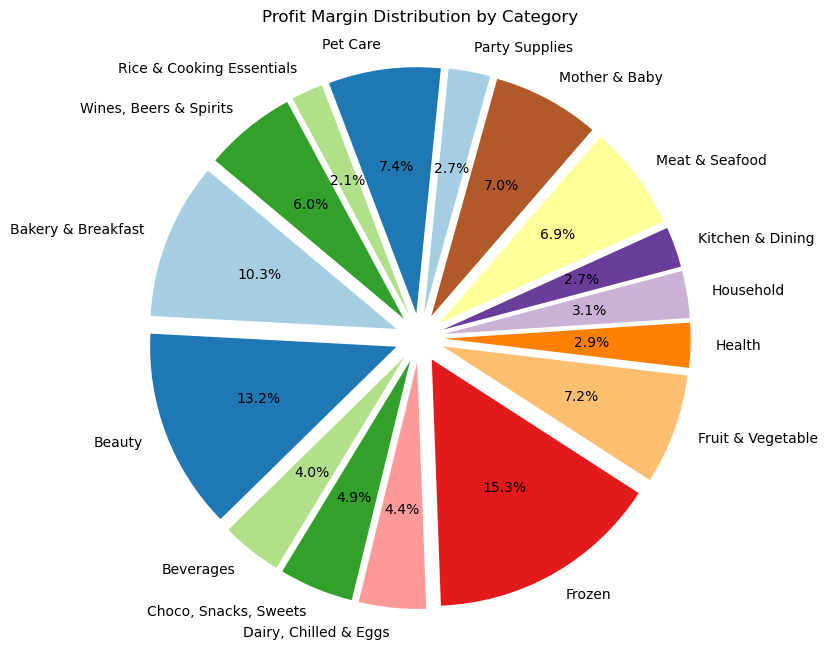

In [15]:
pivot_table = df.pivot_table(index='Category', values='Profit Margin', aggfunc='sum')

plt.figure(figsize=(8, 8))
plt.pie(pivot_table['Profit Margin'], labels=pivot_table.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, explode=[0.1] * len(pivot_table))
plt.title('Profit Margin Distribution by Category')

plt.show()

The categories Frozen, Beauty and Bakery & Breakfast bring the largest share of profit, giving a total of 38.8% of profit.

## 10. Let's highlight the most profitable subcategory of goods in the most profitable category

In [16]:
profit_margin_frozen_subcategory = df[df['Category'] == 'Frozen'].groupby('Sub_Category')['Profit Margin'].sum().sort_values(ascending=False)

max_profitable_frozen_subcategory = profit_margin_frozen_subcategory.idxmax()

print(profit_margin_frozen_subcategory)
print(f"The most profitable category of products is {max_profitable_frozen_subcategory}. Therefore, it is important to always have products of this category in stock");

Sub_Category
Frozen Seafood       3242.88
Frozen Meat          1587.25
Frozen Vegetables    1570.54
Bread & Pasteries    1436.86
Frozen Fruits         738.76
Ice Cream             685.83
Name: Profit Margin, dtype: float64
The most profitable category of products is Frozen Seafood. Therefore, it is important to always have products of this category in stock


## 11. Why does the most profitable category generate the highest profit?

In [17]:
avg_profit_margin_by_category = df.pivot_table(values=['Price','% Profit Margin','Gross Bill Amount'], index=['Category'], aggfunc='mean').round(2)
avg_profit_margin_by_category

,% Profit Margin,Gross Bill Amount,Price
Category,,,
Bakery & Breakfast,0.11,69.46,5.22
Beauty,0.10,80.74,10.06
Beverages,0.09,75.93,8.30
"Choco, Snacks, Sweets",0.11,61.84,5.77
"Dairy, Chilled & Eggs",0.07,62.06,6.90
Frozen,0.12,79.99,7.69
Fruit & Vegetable,0.11,75.37,5.57
Health,0.08,85.95,13.69
Household,0.07,78.41,8.86


The Frozen category has one of the highest levels of profitability next to a high average check, which in total gives the highest volume of profit compared to other product categories, despite the fact that the average price of products in this category is not high compared to other categories. In order to increase volumes the company's profit needs in other categories either to increase the margin percentage, or to increase the average check, or to achieve both goals at the same time.

## 12. What payment method do buyers in different countries use to make purchases on larger checks?

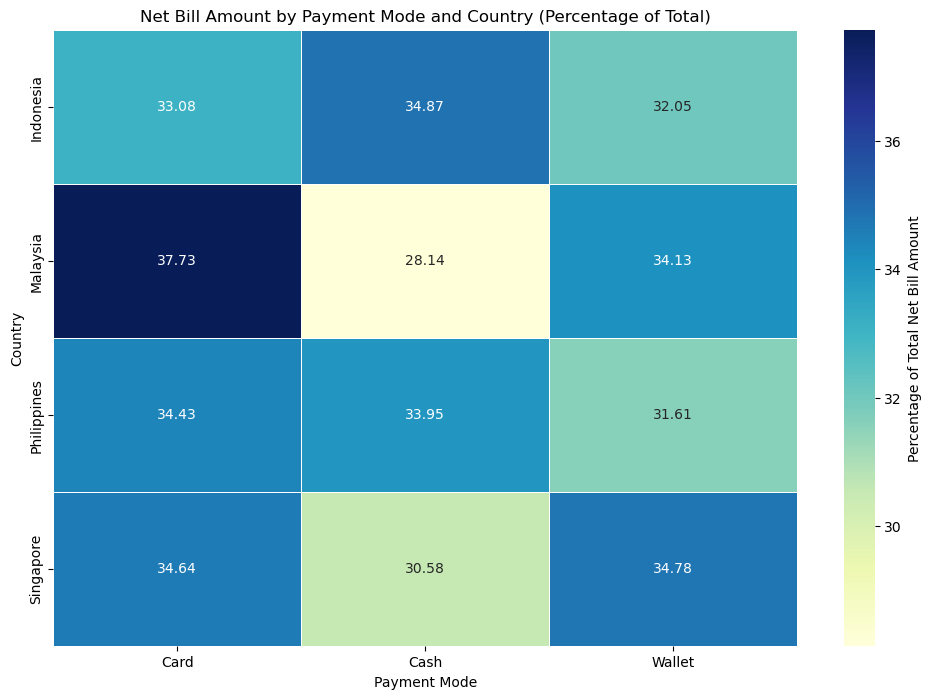

In [18]:
pivot_table = df.pivot_table(values='Net Bill Amount', index=['Country'], columns=['Payment Mode'], aggfunc='sum')

pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table_percentage, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, cbar_kws={"label": "Percentage of Total Net Bill Amount"})
plt.title('Net Bill Amount by Payment Mode and Country (Percentage of Total)')

plt.show()

In Malaysia and the Philippines, card payment method prevails, in Singapore card and e-wallet share almost equal shares, while in Indonesia cash is the most popular payment method.

## 13. Let's check with the help of z-test whether there is a statistically significant difference in payment by card and electronic wallet

In [19]:
net_bill_wallet = df[df['Payment Mode'] == 'Wallet']['Net Bill Amount']
net_bill_card = df[df['Payment Mode'] == 'Card']['Net Bill Amount']

z_statistic, p_value = ztest(net_bill_wallet, net_bill_card)

print(f'Z-statistic: {z_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

alpha = 0.05
if p_value < alpha:
    print('The difference between payment by card and e-wallet is statistically significant')
else:
    print('The difference between payment by card and e-wallet is NOT statistically significant')

Z-statistic: -3.9887
P-value: 0.0001
The difference between payment by card and e-wallet is statistically significant


## 14. Let's check with z-test whether there is a statistically significant difference in payment by card and e-wallet in Singapore

In [20]:
net_bill_wallet_singapore = df[(df['Payment Mode'] == 'Wallet') & (df['Country'] == 'Singapore')]['Net Bill Amount']
net_bill_card_singapore = df[(df['Payment Mode'] == 'Card') & (df['Country'] == 'Singapore')]['Net Bill Amount']

z_statistic, p_value = ztest(net_bill_wallet_singapore, net_bill_card_singapore)

print(f'Z-statistic: {z_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

alpha = 0.05
if p_value < alpha:
    print('The difference in payment by card and e-wallet in Singapore is statistically significant')
else:
    print('The difference in payment by card and e-wallet in Singapore is NOT statistically significant')

Z-statistic: 1.2988
P-value: 0.1940
The difference in payment by card and e-wallet in Singapore is NOT statistically significant
